In [56]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from green_city.utils import span
from scipy.interpolate import CubicSpline
import itertools

In [57]:
b4 = pd.read_csv("../data/preprocessed/Building_4.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

## some aggregation on solar cell power generation

Text(0.5, 1.0, 'Direct solar radiation [W/m2]')

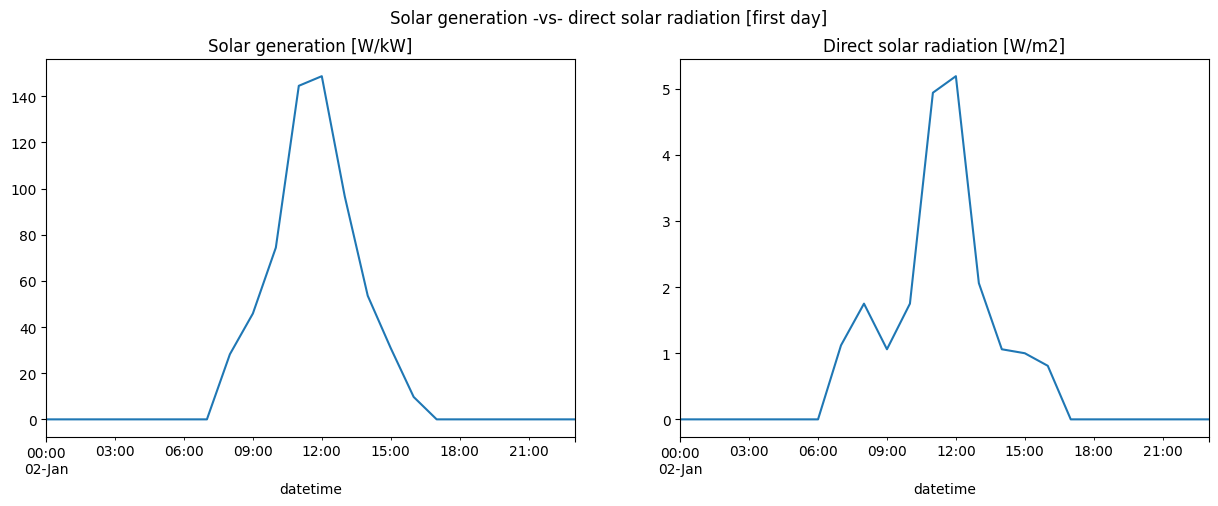

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Solar generation -vs- direct solar radiation [first day]")
b4.loc[span('2008-01-02'), 'solar_generation_W_kW'].plot(ax=ax1) #7 = Solar Generation [W/kW]
ax1.set_title("Solar generation [W/kW]")
b4.loc[span('2008-01-02'), 'direct_solar_W_m2'].plot(ax=ax2);
ax2.set_title("Direct solar radiation [W/m2]")

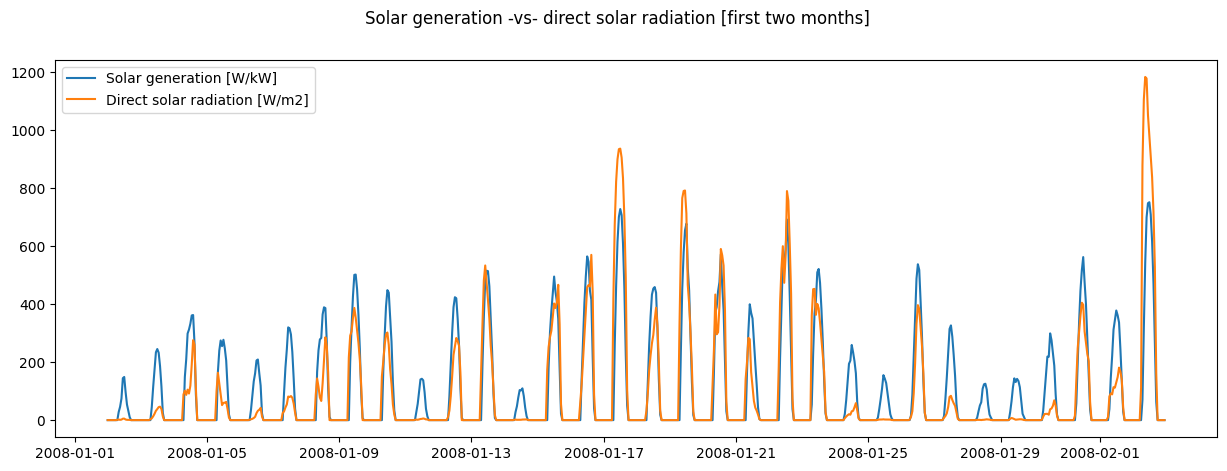

In [59]:
fig, ax = plt.subplots()
fig.suptitle("Solar generation -vs- direct solar radiation [first two months]")
ax.plot("solar_generation_W_kW", data = b4.loc[span('2008-01-02', '2008-02-02'), :], label="Solar generation [W/kW]")
ax.plot("direct_solar_W_m2",     data = b4.loc[span('2008-01-02', '2008-02-02'), :], label="Direct solar radiation [W/m2]")
plt.legend()

In [60]:
is_winter = np.logical_or(b4.index.month < 4, b4.index.month > 9)
winterdays = b4[is_winter]
summerdays = b4[np.logical_not(is_winter)]
print("winter daily avg solar generation: ", winterdays.agg("mean")["solar_generation_kW"])
print("summer daily avg solar generation: ", summerdays.agg("mean")["solar_generation_kW"])
#how does one query for properties of the datetime index?
#b5.query("datetime.dt.hour < 5")

winter daily avg solar generation:  6.259311507519001
summer daily avg solar generation:  7.582144972408243


# Trends and Seasonalities

In [61]:
import seaborn as sns
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [62]:
def get_first_n(series, n = None):
    if not n:
        return series
    return series[:n]
    
def plot_decomposition(decomposition, first_n = None):
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
    observed = get_first_n(decomposition.observed, first_n)
    observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title='Actual temperature')
    trend = get_first_n(decomposition.trend, first_n)
    trend.plot(c=sns_c[1], ax=ax[1])
    ax[1].set(title='trend')
    seasonal = get_first_n(decomposition.seasonal, first_n)
    seasonal.plot(c=sns_c[2], ax=ax[2])
    ax[2].set(title='seasonal')
    resid = get_first_n(decomposition.resid, first_n)
    resid.plot(c=sns_c[3], ax=ax[3])
    ax[3].set(title='residual')
    fig.set_size_inches(20, 10);

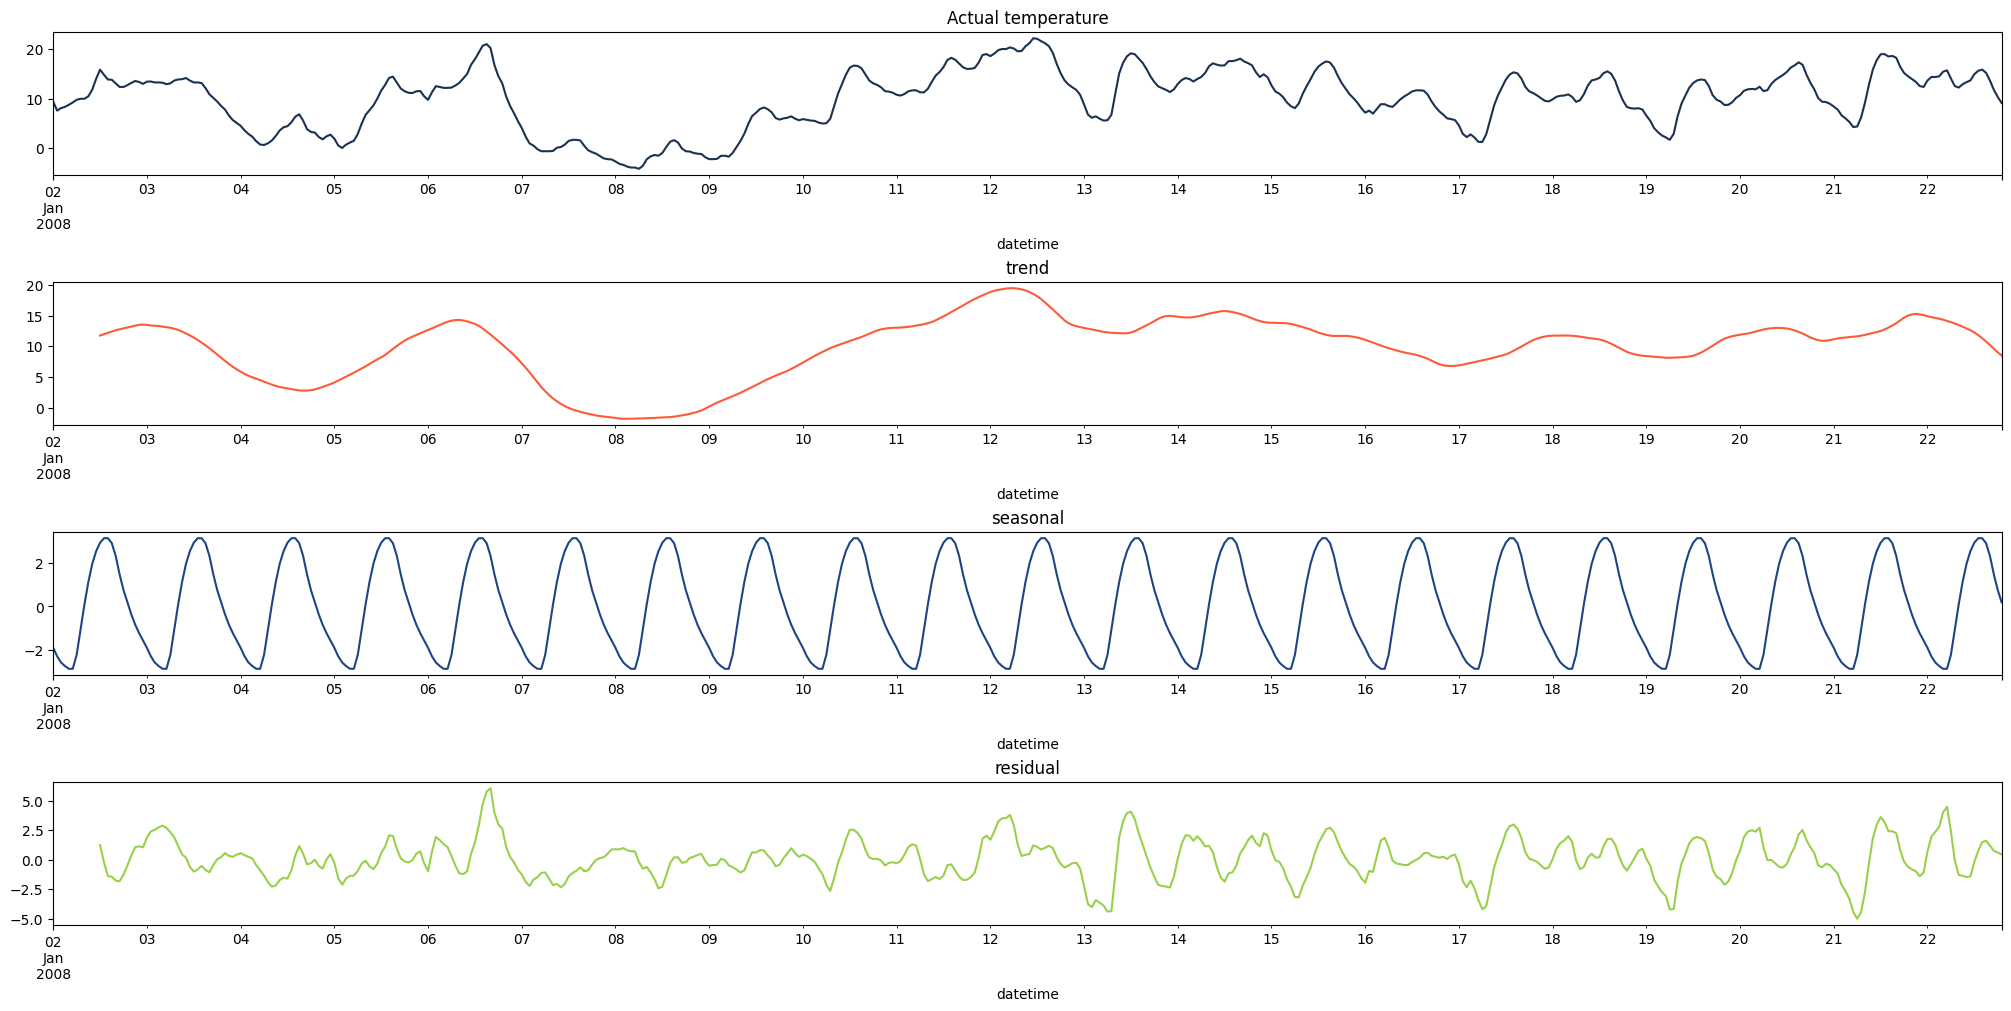

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

orig_data = b4.outdoor_temp
decomposition_dailyseason = seasonal_decompose(x=orig_data,
                                   model='additive',
                                   period=24,)
plot_decomposition(decomposition_dailyseason, 500)

In [64]:
#decomposing multiple seasonalities (doesn't currently work well for me)

##this requires the development version of statsmodels
##and it produces weird results.
#
##https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
##https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stl/mstl.html
##https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530
##from statsmodels.tsa.seasonal import DecomposeResult
#from statsmodels.tsa.stl.mstl import MSTL
#
#mstl_model = MSTL(b5.loc[span("2008-01-02", "2010-05-05"), "outdoor_drybulb_temp_C"], periods=(24 * 365, 24))
#res = mstl_model.fit()
#ax = res.plot()

# De-seasoning piece by piece

In [65]:
b4s = (pd.read_csv("../data/preprocessed/Building_4.csv")
        .astype({'datetime': 'datetime64'})
        [["datetime", "net_load_kWh"]]
        .rename(columns={"net_load_kWh": "actual"})
        .assign(dayofyear = lambda x: x.datetime.dt.dayofyear)
)

b4s.head()

,datetime,actual,dayofyear
0,2008-01-02 00:00:00,0.44,2
1,2008-01-02 01:00:00,0.44,2
2,2008-01-02 02:00:00,0.44,2
3,2008-01-02 03:00:00,0.44,2
4,2008-01-02 04:00:00,0.44,2


## De-trending and de-seasoning yearly seasons
- fitting trigonometric functions to detect seasonality

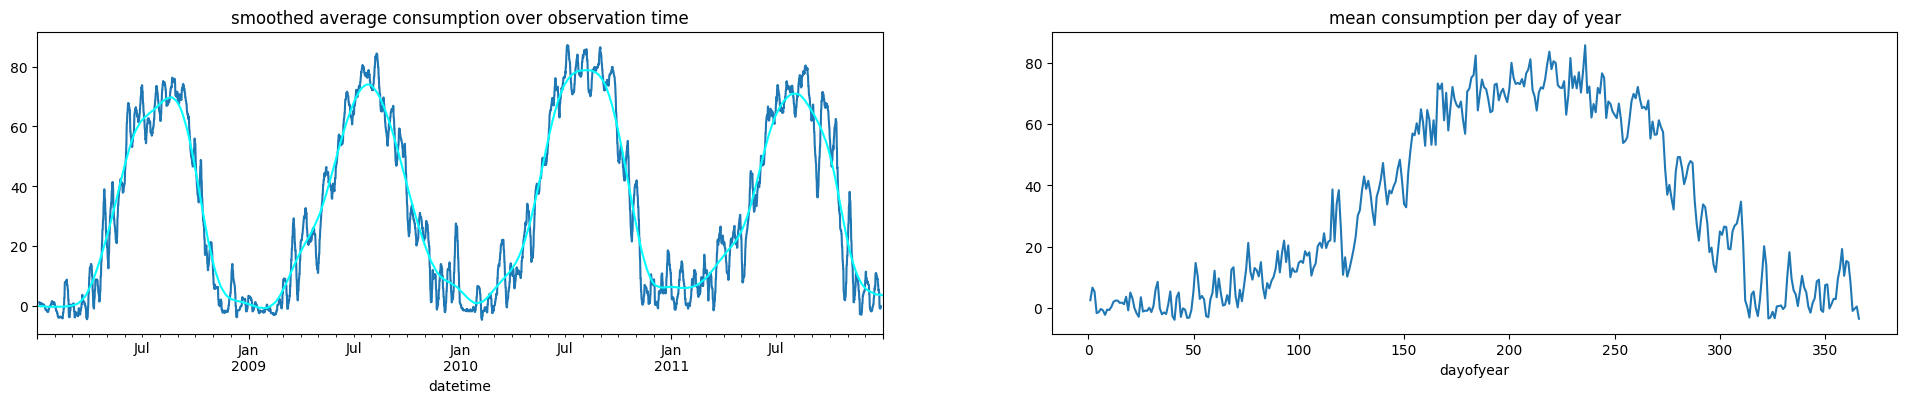

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,4))
b4s.set_index("datetime").rolling(24*7, center=True).mean()["actual"].plot(ax=ax1, title="smoothed average consumption over observation time")
b4s.set_index("datetime").actual.rolling(24*28*3, win_type = 'hamming', center=True, min_periods=1).mean().plot(color="cyan", ax=ax1)

b4s.groupby("dayofyear").mean()["actual"].plot(ax=ax2, title="mean consumption per day of year");

#plt.figure()


trig. mse for d=1: 49.75028392152539
trig. mse for d=2: 18.604850396339753
trig. mse for d=3: 16.642295653326507
trig. mse for d=4: 11.36296307736778
trig. mse for d=5: 11.277585474535874
trig. mse for d=6: 10.836869588123236
trig. mse for d=7: 10.737897385427535


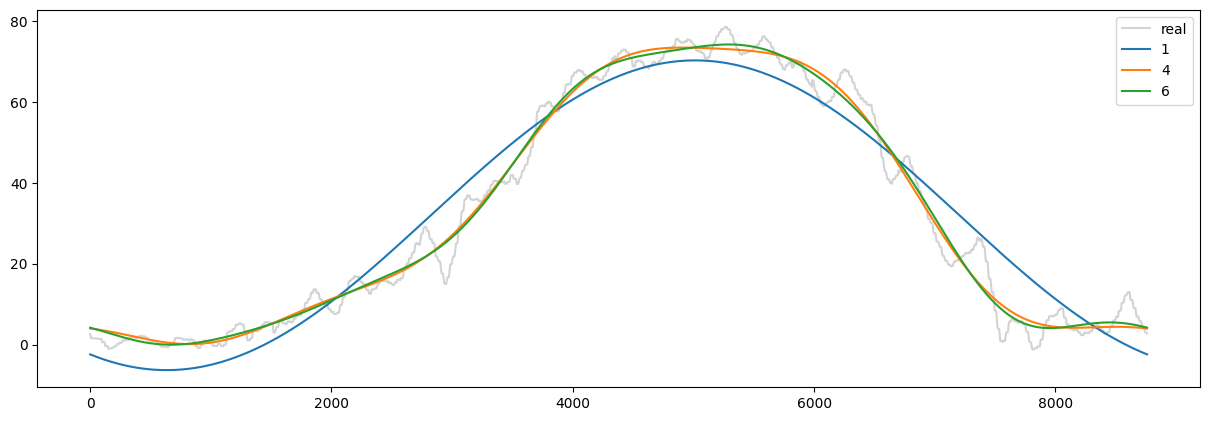

In [67]:
def harmonic_approx(x, season_length, coef, intercept=0):
    sum = np.zeros(x.shape) + intercept

    for (i, (c, trig_fun)) in enumerate(zip(coef, itertools.cycle([np.sin, np.cos]))):
        d = i//2+1
        sum += c * trig_fun(x * d * 2*np.pi / season_length)
    
    return sum


def fit_tri(ydata, harmonic_degree, x=None):

    if x is None:
        x = ydata.index #assuming that ydata is a Series

    harmonics = range(1, harmonic_degree+1)

    basis = []
    for multiplier in harmonics:
        basis.append(pd.Series( np.sin(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_sin'))
        basis.append(pd.Series( np.cos(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_cos'))

    trig_basis = pd.concat(basis, axis=1)

    lr = LinearRegression()
    model = lr.fit(trig_basis, ydata)

    approximation_result = harmonic_approx(x, season_length, model.coef_, model.intercept_)

    return (model, approximation_result)


season_length = 365*24

##############################################
#Approach 2: periodic-boundary-smoothing for the mean year
##############################################
shifts = len(b4s)//season_length # =4

net_load = b4s["actual"]
avg_net_load = (sum([net_load.shift(-i*24*365) for i in range(shifts)])/shifts)[:season_length]
#avg_net_load = pd.concat([net_load.shift(-i*24*365)[:season_length] for i in range(shifts)], axis=1).agg('mean', axis=1)

#make three copies such that using the rolling average will produce a periodic window when cutting out the middle third afterwards
y_data = pd.concat([avg_net_load]*3, axis=0).rolling(24*7, center=True).mean()[season_length:2*season_length]
##############################################

plt.plot(y_data, label="real", color="lightgray")
for degree in range(1, 8):
    model, y_season = fit_tri(y_data, degree)
    print(f"trig. mse for d={degree}:", mean_squared_error(y_season, y_data))
    if degree in [1,4,6]:
        plt.plot(y_season, label=str(degree))
plt.legend();

In [68]:
model, _ = fit_tri(y_data, 4)
b4s["season_Y"] = harmonic_approx(b4s.index, season_length, model.coef_, model.intercept_)
b4s.head()

,datetime,actual,dayofyear,season_Y
0,2008-01-02 00:00:00,0.44,2,3.992711
1,2008-01-02 01:00:00,0.44,2,3.989175
2,2008-01-02 02:00:00,0.44,2,3.985625
3,2008-01-02 03:00:00,0.44,2,3.982061
4,2008-01-02 04:00:00,0.44,2,3.978483


### De-trending

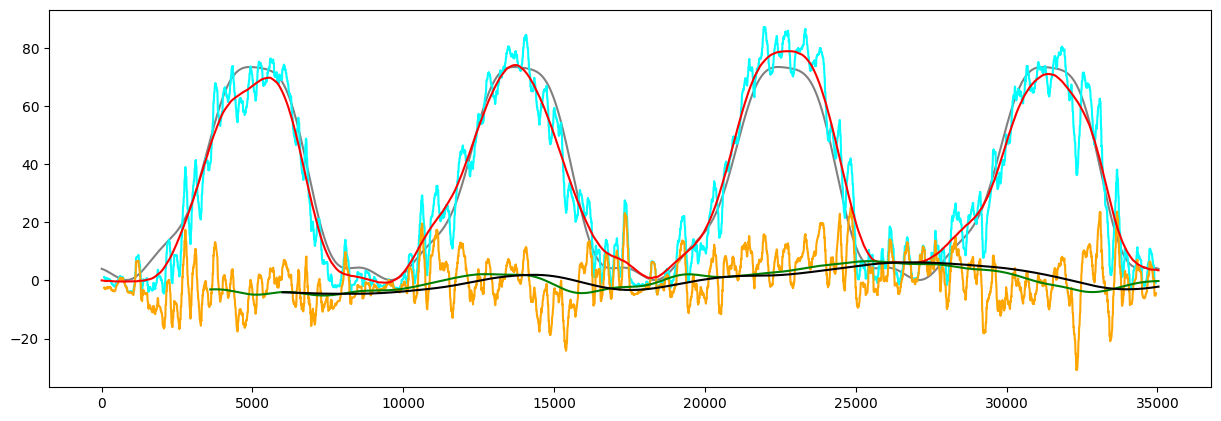

In [69]:
plt.plot(b4s.season_Y, color="gray")
plt.plot(b4s.actual.rolling(24*7, center=True).mean(), color="cyan")

plt.plot(b4s.actual.rolling(24*7, center=True).mean() - b4s.season_Y, color="orange")
plt.plot(b4s.actual.rolling(24*28*3, win_type = 'hamming', center=True, min_periods=1).mean(), color="red")

#(b4s.actual.rolling(24*28*3, win_type = 'hamming', center=True, min_periods=1).mean() - b4s.season_Y).rolling(24*4, center=True, min_periods=1).mean().plot(color="blue")

trend = (b4s.actual.rolling(24*28*3, win_type = 'hamming', center=True, min_periods=1).mean() - b4s.season_Y).rolling(24*150).mean()#.plot(color="black")
trend.plot(color="green")
trend.rolling(24*100).mean().plot(color="black")

b4s["trend"] = trend

In [73]:
decomp = pd.DataFrame({"data": b4s["actual"], "season": b4s["season_Y"], "trend": trend, "datetime": b4s["datetime"]})
decomp["deseasoned_year"] = decomp.data - decomp.season - decomp.trend

### Dealing with weekly seasonality
- after substracting the weekday-avg deviations, look if over the year the weekday-adjustments are actually changing (same will hold when deseasoning hours)

<AxesSubplot:xlabel='day_tot'>

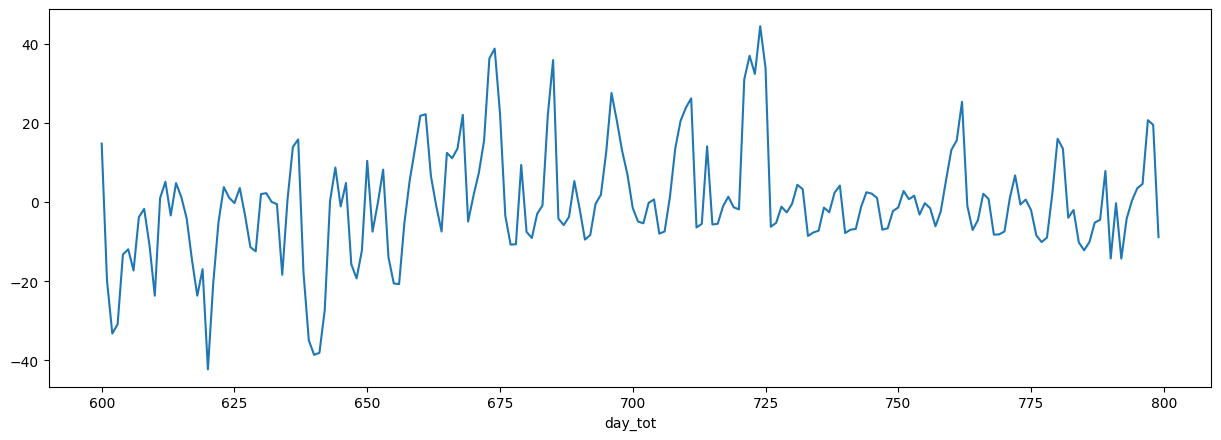

In [76]:
plot_week_acf = False
if plot_week_acf:
    decomp["weekerror"] = (decomp.data.rolling(24*7, center=True, min_periods=1).mean() - decomp.season - decomp.trend)
    decomp['week_tot'] = [i//(24*7) for i in range(len(decomp))]
    plot_acf(decomp.groupby("week_tot").mean().weekerror, lags=70);

decomp["weekday"] = decomp.datetime.dt.weekday
decomp["hour"] = decomp.datetime.dt.hour
decomp['day_tot'] = [i//(24) for i in range(len(decomp))]

weekday_correction = decomp.groupby("weekday").mean()["deseasoned_year"].to_numpy()
decomp["week_season"] = list(map(lambda x: weekday_correction[x], decomp.weekday))
decomp["deseasoned_week"] = decomp.data - decomp.season - decomp.trend - decomp.week_season
decomp.groupby("day_tot").mean()["deseasoned_week"].iloc[600:800].plot()

### Day deseasoning

/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


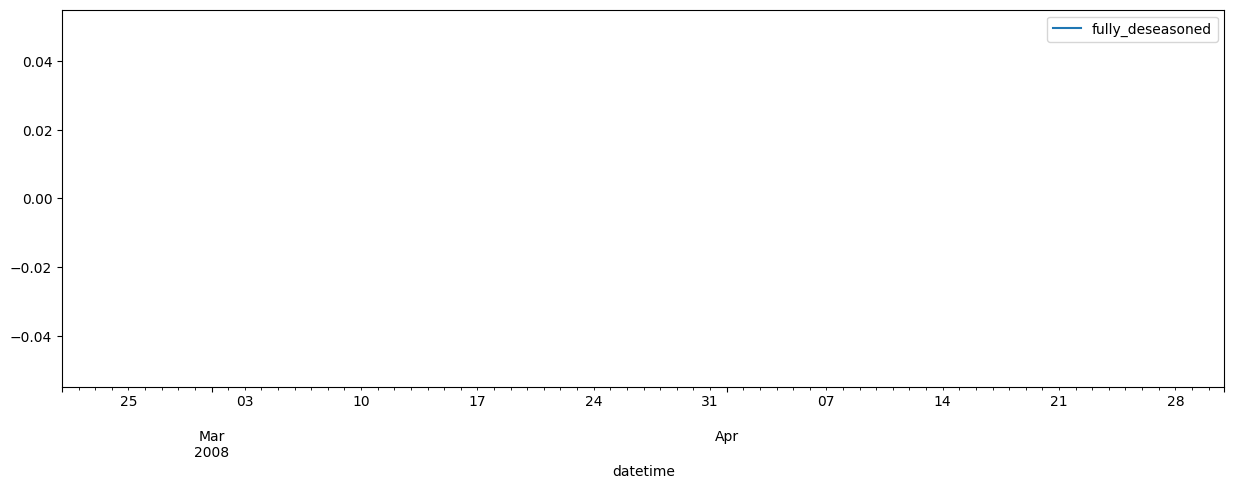

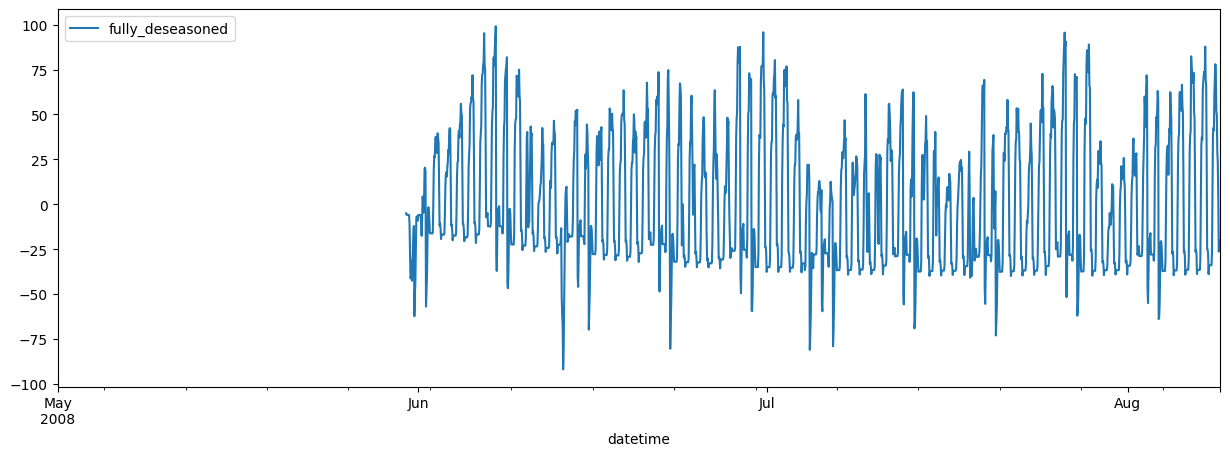

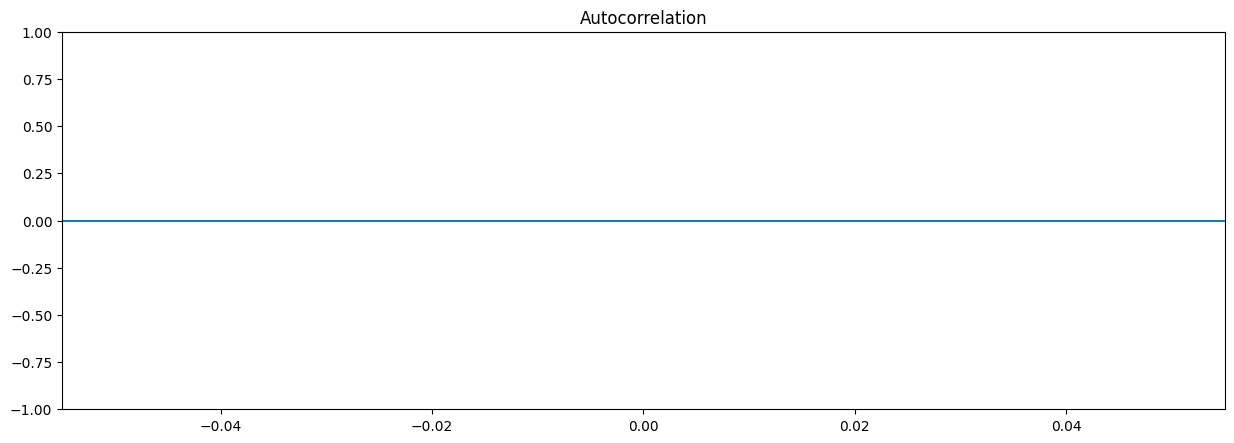

In [75]:
#decomp.groupby("hour").mean()["deseasoned_week"].plot()
hour_correction = decomp.groupby("hour").mean()["deseasoned_week"].to_numpy()
decomp["day_season"] =  list(map(lambda x: hour_correction[x], decomp.hour))
decomp["fully_deseasoned"] =  decomp.data - decomp.season - decomp.trend - decomp.week_season - decomp.day_season
decomp.set_index("datetime").iloc[50*24:120*24].plot(y = "fully_deseasoned")
decomp.set_index("datetime").iloc[120*24:220*24].plot(y = "fully_deseasoned")

plot_acf(decomp.fully_deseasoned, lags=70);

### Fitting splines

In [ ]:
smooth_data = year_avg.rolling(24*4, center=True, min_periods=1).mean()
smooth_data

In [ ]:
np.mean([2,3.1,1])